<div align="center">

# Глубокое обучение нейронных сетей на основе PyTorch
    
</div>

---

## PyTorch и производительность обучения 



#### Проблемы с быстродействием

CPU имеют ограниченное число ядер (обычно до 16), а Python из-за глобальной блокировки интерпретатора(Global Inerpreter Lock, GIL) плохо масштабируется на многопоточность. Даже простые нейросети требуют десятков тысяч параметров, и с ростом сложности моделей вычислительная нагрузка быстро становится неподъёмной для процессора.

#### Решение: GPU

GPU содержат тысячи ядер и в десятки раз превосходят CPU в параллельных вычислениях, что делает их основным инструментом для обучения глубоких моделей.

#### Преимущество PyTorch

PyTorch упрощает использование GPU: достаточно перенести модель и данные на устройство, и все вычисления будут выполняться с аппаратным ускорением без необходимости писать код на CUDA.


---


## Что такое PyTorch?

**PyTorch** — это масштабируемая многоплатформенная библиотека для реализации и запуска алгоритмов машинного обучения, особенно глубокого обучения. Она была опубликована в 2016 году под модифицированной лицензией BSD и быстро стала популярной как среди исследователей, так и в индустрии. PyTorch используется в таких проектах, как **Tesla Autopilot**, **Uber Pyro** и **Hugging Face Transformers**.


#### Где выполняются вычисления: CPU, GPU, TPU

PyTorch умеет переносить вычисления на разные типы устройств:

* **CPU** — центральный процессор. Подходит для небольших моделей, но ограничен по числу ядер и плохо масштабируется на большие матрицы и тензоры.
* **GPU** — графический процессор. Содержит тысячи ядер для параллельных вычислений. PyTorch поддерживает GPU через:

  * **CUDA** (NVIDIA),
  * **ROCm** (AMD).
    Это основной способ ускорения обучения.
* **TPU (через XLA)** — специализированные тензорные процессоры от Google для глубокого обучения.

> На практике: большие модели с миллионами параметров на CPU обучаются медленно. GPU/TPU дают ускорение в десятки раз.


#### Граф вычислений и стиль программирования

PyTorch строит **граф вычислений**, где:

* **узлы** = операции (сложение, умножение матриц, функции активации),
* **рёбра** = данные (тензоры), которые «текут» между узлами.

Особенность PyTorch — **императивный стиль** (*eager execution*): операции выполняются сразу, а граф строится неявно.

> Преимущество: легко отлаживать и экспериментировать, ошибки видны сразу, без отдельной компиляции графа.


#### Тензоры в PyTorch

**Тензор** — основной тип данных в PyTorch, обобщающий скаляры, векторы, матрицы и многомерные массивы:

* **ранг 0** → скаляр (`5`)
* **ранг 1** → вектор (`[1, 2, 3]`)
* **ранг 2** → матрица (`3×3`)
* **ранг 3** → куб данных (стопка изображений)
* **ранг N** → многомерный массив

Тензоры похожи на массивы NumPy, но оптимизированы для GPU и поддерживают **автоматическое дифференцирование** через `torch.autograd`.

> Пример: операция умножения матриц в PyTorch не только возвращает результат, но и запоминается в графе вычислений для вычисления градиентов.


#### Как мы будем изучать PyTorch

1. Создание тензоров и управление ими.
2. Загрузка данных через `torch.utils.data` и использование готовых датасетов.
3. Построение и обучение моделей с помощью `torch.nn`.
4. Сохранение и повторное использование обученных моделей.

---


In [101]:
import torch
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
import torchvision.transforms as transforms
import torchvision
from itertools import islice
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import torch.nn as nn

In [102]:
# Способы создания тензоров, которые можно создать из простого
# списка или массива NumPy

# Настройка вывода NumPy: числа будут показываться с 3 знаками после запятой
np.set_printoptions(precision=3)

# Создаём обычный список Python
a = [1, 2, 3]

# Создаём массив NumPy с типом данных int32
b = np.array([4, 5, 6], dtype=np.int32)

# Создаём тензор PyTorch из списка Python
# PyTorch сам определяет тип данных (по умолчанию int64 для целых чисел)
t_a = torch.tensor(a)

# Создаём тензор PyTorch из массива NumPy
# Тензор и массив будут делить память: изменения в одном изменят другой
t_b = torch.from_numpy(b)

print(t_a)  
print(t_b)  

tensor([1, 2, 3])
tensor([4, 5, 6], dtype=torch.int32)


In [103]:
# Можно просмотреть свойства
t_ones = torch.ones(2, 3)
t_ones.shape


torch.Size([2, 3])

In [104]:
print(t_ones)

tensor([[1., 1., 1.],
        [1., 1., 1.]])


In [105]:
# Можно создать тензор случайных значений
rand_tensor = torch.rand(2, 3)
print(rand_tensor)

tensor([[0.5776, 0.6306, 0.4131],
        [0.2652, 0.5923, 0.0867]])


---

## Управление типом данных и формой тензора

Умение управлять тензорами необходимо для корректного ввода их в модели или операции. В PyTorch это достигается с помощью функций, которые изменяют **тип данных**, **форму** и выполняют операции **транспонирования** или **сжатия измерений**.

### 1. Изменение типа данных

Функция `torch.to()` позволяет преобразовать тензор в нужный тип данных. Это важно, потому что разные операции и модели требуют определённого типа данных (например, `float32` для нейросетей).

### 2. Изменение формы и ранга

Некоторые операции требуют, чтобы тензор имел конкретный **ранг** (количество измерений) и **форму** (количество элементов по каждому измерению). PyTorch предоставляет следующие функции:

* `torch.reshape()` — изменяет форму тензора без изменения данных.
* `torch.transpose()` — меняет местами выбранные измерения.
* `torch.squeeze()` — удаляет измерения размером 1.

Эти операции позволяют добавить новые измерения, удалить лишние или переставить их, чтобы тензор соответствовал требованиям модели.

---


In [106]:
# Изменение типа данных тензора
a = np.array([1, 3, 4], dtype=np.int32)
t_a = torch.tensor(a)
t_a_new = t_a.to(torch.int64)
print(t_a_new.dtype)

torch.int64


In [107]:
# Транспонирование тензора

t = torch.rand(3, 5) 

# Транспонируем тензор, меняем местами оси 0 и 1
t_tr = torch.transpose(t, 0, 1)  

print(t.shape, '-->', t_tr.shape) 


torch.Size([3, 5]) --> torch.Size([5, 3])


In [108]:
# Изменение формы тензора (например, преобразование из 
# одномерного вектора в двумерный массив)
t = torch.zeros(30)
t_reshape = t.reshape(5, 6)
print(t_reshape.shape)

torch.Size([5, 6])


In [109]:
# Удаление ненужных измерений
t = torch.zeros(1, 2, 1, 4, 1)
t_sqz = torch.squeeze(t, 2)
print(t.shape, '-->', t_sqz.shape)

torch.Size([1, 2, 1, 4, 1]) --> torch.Size([1, 2, 4, 1])


---

## Применение к тензорам математических операций

В ML не обойтись без математичесих процедур, особенно без линейной алгебры. Рассмотрим широко используемые операции в ЛА:
* поэлементное произведение;
* умножение матриц;
* вычисление нормы тензора.

Создадим для этого два случайных тензора, один с равномерным распределением [-1, 1), второй же со стандартным нормальным распределением. Кстати говоря, метод `torch.rand` возвращает тензор, заполненный случайными числами из равномерного распределения [0, 1).

Для вычисления среднего значения, суммы и стандартного отклонения по определенной оси или осям предназначены функции: `torch.mean()`, `torch.sum()`, `torch.std()`.

---

In [110]:
# Создание тензоров
t1 = 2 * torch.rand(5, 2) - 1
t2 = torch.normal(mean=0, std=1, size=(5, 2))
print(t1)
print(t2)

tensor([[-0.0345,  0.0445],
        [ 0.9201,  0.3193],
        [ 0.4881, -0.4278],
        [-0.3429,  0.7274],
        [ 0.3666,  0.2508]])
tensor([[ 1.8060, -0.1873],
        [ 0.3080, -0.8639],
        [ 1.2691, -1.3156],
        [-0.4491, -1.2438],
        [-0.3768, -1.3249]])


In [111]:
# Поэлементное произведение
t3 = torch.multiply(t1, t2)
print(t3)

tensor([[-0.0623, -0.0083],
        [ 0.2834, -0.2758],
        [ 0.6195,  0.5628],
        [ 0.1540, -0.9048],
        [-0.1382, -0.3322]])


In [112]:
# Среднее значение каждого столбца можно вычислить так
t4 = torch.mean(t1, axis = 0)
print(t4)

tensor([0.2795, 0.1828])


In [113]:
# Матричное произведение с транспонированием можно вычислить так
t5 = torch.matmul(t1, torch.transpose(t2, 0, 1))
print(t5)

tensor([[-0.0707, -0.0491, -0.1024, -0.0399, -0.0460],
        [ 1.6019,  0.0076,  0.7478, -0.8103, -0.7697],
        [ 0.9617,  0.5200,  1.1823,  0.3129,  0.3828],
        [-0.7555, -0.7341, -1.3922, -0.7508, -0.8345],
        [ 0.6151, -0.1037,  0.1353, -0.4766, -0.4704]])


In [114]:
# Матричное произведение с транспонированием 
t6 = torch.matmul(torch.transpose(t1, 0, 1), t2)
print(t6)

tensor([[ 0.8564, -1.4899],
        [-0.7854, -0.9583]])


##### Функция `torch.linalg.norm()`

`torch.linalg.norm()` используется для вычисления **нормы тензора**. Норма — это числовая характеристика «размера» или «длины» тензора.

В зависимости от значения параметра `ord`, можно вычислять разные **Lₚ-нормы**:

* **L1-норма** (`ord=1`) — сумма абсолютных значений всех элементов.
* **L2-норма** (`ord=2`) — корень из суммы квадратов всех элементов (классическая «евклидова длина»).
* Другие значения `ord` позволяют вычислять более общие нормы.

**Параметр `dim`** позволяет вычислять норму вдоль выбранного измерения тензора, а не по всем элементам сразу. Например, для матрицы можно посчитать L2-норму каждой строки или каждого столбца.

**Объяснение:**

* Для вектора `[3, 4]` L2-норма = √(3² + 4²) = 5.0
* Для матрицы с `dim=1` L2-норма вычисляется для каждой строки отдельно:

  * `[3,4]` → 5.0
  * `[1,2]` → √(1²+2²) ≈ 2.236

> Параметр `dim` делает `torch.linalg.norm()` очень гибкой для вычислений по отдельным осям многомерных тензоров.


In [115]:
# Вычисление L2-нормы тензора 
norm_t1 = torch.linalg.norm(t1, ord=2, dim=1)
print(norm_t1)

tensor([0.0564, 0.9740, 0.6491, 0.8042, 0.4442])


---

## Разделение, стекирование и конкатенация тензоров

В PyTorch есть удобные функции для **разделения одного тензора на несколько** и для **объединения нескольких тензоров в один**.

#### 1. Разделение тензоров

* `torch.chunk(tensor, chunks, dim=0)` — делит тензор на `chunks` равных частей вдоль измерения `dim`. Если размер тензора не кратен кол-ву разбиений, последний фрагмент будет меньше.

* `torch.split(tensor, split_sizes, dim=0)` — делит тензор на фрагменты указанного размера (может быть список размеров).

#### 2. Стекирование и объединение тензоров

* `torch.stack(tensors, dim=0)` — создаёт новый тензор, добавляя новое измерение и «укладывая» входные тензоры вдоль него.
* `torch.cat(tensors, dim=0)` — объединяет входные тензоры вдоль существующего измерения, не создавая нового.

> Эти операции полезны при подготовке данных, формировании батчей и построении моделей, где требуется манипуляция с формой тензоров.

---

In [116]:
# Разделение тензора через функцию chunk()

# разбиение на куски будет одинаковым каждый раз, потому что сам тензор одинаковый.
torch.manual_seed(1)
t = torch.rand(6)
print(t)
t_splits = torch.chunk(t, 3)
print(t_splits)

tensor([0.7576, 0.2793, 0.4031, 0.7347, 0.0293, 0.7999])
(tensor([0.7576, 0.2793]), tensor([0.4031, 0.7347]), tensor([0.0293, 0.7999]))


In [117]:
# Разделение тензора через функцию split()
torch.manual_seed(1)
t = torch.rand(5)
print(t)
t_splits = torch.split(t, split_size_or_sections = [3, 2])
print(t_splits)

tensor([0.7576, 0.2793, 0.4031, 0.7347, 0.0293])
(tensor([0.7576, 0.2793, 0.4031]), tensor([0.7347, 0.0293]))


In [118]:
# Выполним конкатенацию (объеденение)
A = torch.ones(3)
B = torch.zeros(2)
C = torch.cat([A, B], axis=0)
print(A)
print(B)
print(C)

tensor([1., 1., 1.])
tensor([0., 0.])
tensor([1., 1., 1., 0., 0.])


In [119]:
# Выполним Стекирование (укладка штабелем)
A = torch.ones(3)
B = torch.zeros(3)
S = torch.stack([A, B], axis=1)
print(S)

tensor([[1., 0.],
        [1., 0.],
        [1., 0.]])


<div align="center">

## Построение конвейеров ввода в PyTorch
    
</div>

---

При обучении глубоких нейросетей данные обычно подаются **пакетами** в итеративный алгоритм оптимизации, такой как стохастический градиентный спуск.

* Если обучающий набор **мал** и помещается в память, можно использовать тензор напрямую.
* В реальных сценариях данные часто слишком велики для памяти, поэтому их приходится **загружать с диска пакетами**.

Кроме того, часто требуется **предварительная обработка данных**:

* центрирование и нормализация,
* масштабирование,
* добавление шума или аугментация, чтобы расширить набор данных и снизить риск переобучения.

Ручная организация таких конвейеров неудобна. PyTorch предоставляет удобные инструменты:

* **`Dataset`** — объект, описывающий набор данных и способы доступа к нему;
* **`DataLoader`** — класс для загрузки данных пакетами, их перетасовки и организации итераций.

С помощью этих инструментов можно легко строить **эффективные конвейеры ввода**, объединяющие загрузку, пакетную обработку и предварительную трансформацию данных.

---

## Создание объекта DataLoader из существующих тензоров

In [120]:
# Создадим тензор с данными
t = torch.arange(6, dtype=torch.float32)

# Инициализируем объект
data_loader = DataLoader(t)

# Переберем наши данные
for item in data_loader:
    print(item)

tensor([0.])
tensor([1.])
tensor([2.])
tensor([3.])
tensor([4.])
tensor([5.])


Если надо из набора данных создать пакеты размером ну например 3, то можно воспользоваться аргументом **batch_size**. Получается, что первые три элемента перейдут в пакет 1б а остальные элементы в пакет 2. Аргумент **drop_last** полезен, когда кол-во элементов в тензоре не кратно желаемому размеру пакета. Мы можем удалить последний неполный пакет установив значение `True`.

In [121]:
# Создание пакетов 
data_loader = DataLoader(t, batch_size = 3, drop_last = False)

# Перебор данных с пакетами
for i, batch in enumerate(data_loader, 1):
    print(f'batch {i}:', batch)

batch 1: tensor([0., 1., 2.])
batch 2: tensor([3., 4., 5.])


---

## Объединение двух тензоров в совместный набор данных

Часто данные хранятся в нескольких тензорах, например:

* `t_x` — тензор признаков (каждый элемент размером 3),
* `t_y` — тензор меток классов.

Чтобы использовать их вместе в обучении, нужно создать **совместный набор данных**, который возвращает элементы в виде кортежей `(x, y)`.

#### 1. Пользовательский класс `Dataset`

Можно создать свой класс `Dataset`, реализующий два метода:

* `__init__()` — выполняет предварительную работу: загрузку тензоров, фильтрацию данных и т.д.
* `__getitem__(index)` — возвращает образец по индексу `(t_x[index], t_y[index])`.

После этого создаётся совместный набор данных из `t_x` и `t_y` через этот класс. Можно итерироваться по нему и получать все записи.

#### 2. Использование `TensorDataset`

Если оба набора данных представлены тензорами, PyTorch предлагает готовое решение: **`torch.utils.data.TensorDataset`**. Оно автоматически объединяет тензоры, гарантируя соответствие элементов.

> Важно: при объединении нескольких тензоров нужно следить за сохранением **поэлементного соответствия** признаков и меток. Потеря синхронизации может произойти, если тензоры перемешиваются отдельно.

#### 3. Загрузка файлов изображений

Если данные представлены списком имён файлов, можно определить функцию для **загрузки изображений по имени** и объединить результаты с метками, создавая собственный `Dataset`.

---

In [122]:
# Создадим два тензора
torch.manual_seed(1)
t_x = torch.rand([4, 3], dtype=torch.float32)
t_y = torch.arange(4)

In [123]:
# Создадим класс для формирования двух тензоров
class JoinDataset(Dataset):
    # Выполняет предварительную работу
    def __init__(self, x, y):
        self.x = x
        self.y = y

    # Возвращает длину признака
    def __len__(self):
        return len(self.x)


    # Возвращает образец по индексу 
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [124]:
# Или создать класс от torch
join_dataset = TensorDataset(t_x, t_y)
for example in join_dataset:
    print(f'x: {example [0]} y: {example[1]}')

x: tensor([0.7576, 0.2793, 0.4031]) y: 0
x: tensor([0.7347, 0.0293, 0.7999]) y: 1
x: tensor([0.3971, 0.7544, 0.5695]) y: 2
x: tensor([0.4388, 0.6387, 0.5247]) y: 3


---

## Перемешивание, группировка и повторение

При обучении нейросетевой модели с использованием оптимизации методом **стохастического градиентного спуска (SGD)** крайне важно подавать данные **в случайном порядке**. Это связано с тем, что SGD обновляет веса модели на основе **каждого пакета данных**; если данные идут в порядке, близком к исходному, градиенты могут быть смещены, что ухудшает обучение.

* Размер пакета задаётся через аргумент `batch_size` объекта `DataLoader`.
* PyTorch позволяет **перемешивать данные** (`shuffle=True`) при формировании пакетов.
* Также можно **повторять набор данных** при необходимости (циклический обход), что удобно для малых наборов или объединённых тензоров.

---

In [125]:
# Создадим перемешивающую версию загрузчика данных
torch.manual_seed(1)
data_loader = DataLoader(dataset=join_dataset, batch_size=2, shuffle=True)

# Перебор записей загрузчика
for i, batch in enumerate(data_loader, 1):
    print(f'batch {i}:', 'x:', batch[0],
          '\n           y:', batch[1])

batch 1: x: tensor([[0.3971, 0.7544, 0.5695],
        [0.7576, 0.2793, 0.4031]]) 
           y: tensor([2, 0])
batch 2: x: tensor([[0.7347, 0.0293, 0.7999],
        [0.4388, 0.6387, 0.5247]]) 
           y: tensor([1, 3])


In [126]:
# Перетасовка в течение эпох
for epoch in range(2):
    print(f'epoch {epoch+1}')
    for i, batch in enumerate(data_loader, 1):
        print(f'barch {i}:', 'x:', batch[0],
             '\n y:', batch[1])

epoch 1
barch 1: x: tensor([[0.7576, 0.2793, 0.4031],
        [0.3971, 0.7544, 0.5695]]) 
 y: tensor([0, 2])
barch 2: x: tensor([[0.7347, 0.0293, 0.7999],
        [0.4388, 0.6387, 0.5247]]) 
 y: tensor([1, 3])
epoch 2
barch 1: x: tensor([[0.4388, 0.6387, 0.5247],
        [0.3971, 0.7544, 0.5695]]) 
 y: tensor([3, 2])
barch 2: x: tensor([[0.7576, 0.2793, 0.4031],
        [0.7347, 0.0293, 0.7999]]) 
 y: tensor([0, 1])


---

## Создание набора данных из файлов на локальном диске

На практике данные для обучения моделей хранятся в виде файлов (например, изображений или текстов). Чтобы использовать их в PyTorch, нужно построить набор данных, который будет загружать и преобразовывать файлы в тензоры.

В примере используется небольшая коллекция изображений кошек и собак (папка `ch12/cat_dog_images/`, содержащая 6 JPEG-файлов). Она демонстрирует общий подход к созданию набора данных из локально сохранённых файлов.

Для этого применяются:

* **`PIL.Image`** — открывает и декодирует изображения;
* **`torchvision.transforms`** — выполняет преобразования (например, изменение размера, преобразование в тензор).

Такой конвейер позволяет последовательно загружать изображения с диска, применять к ним предобработку и передавать их в модель.

---

In [127]:
# Просмотр содержимого
imgdir_path = pathlib.Path('Data/cat_dog_images')
file_list = sorted([str(path) for path in imgdir_path.glob('*.jpg')])
print(file_list)

['Data/cat_dog_images/cat-01.jpg', 'Data/cat_dog_images/cat-02.jpg', 'Data/cat_dog_images/cat-03.jpg', 'Data/cat_dog_images/dog-01.jpg', 'Data/cat_dog_images/dog-02.jpg', 'Data/cat_dog_images/dog-03.jpg']


Размеры изображения:  (900, 1200, 3)
Размеры изображения:  (900, 1200, 3)
Размеры изображения:  (900, 742, 3)
Размеры изображения:  (800, 1200, 3)
Размеры изображения:  (800, 1200, 3)
Размеры изображения:  (900, 1200, 3)


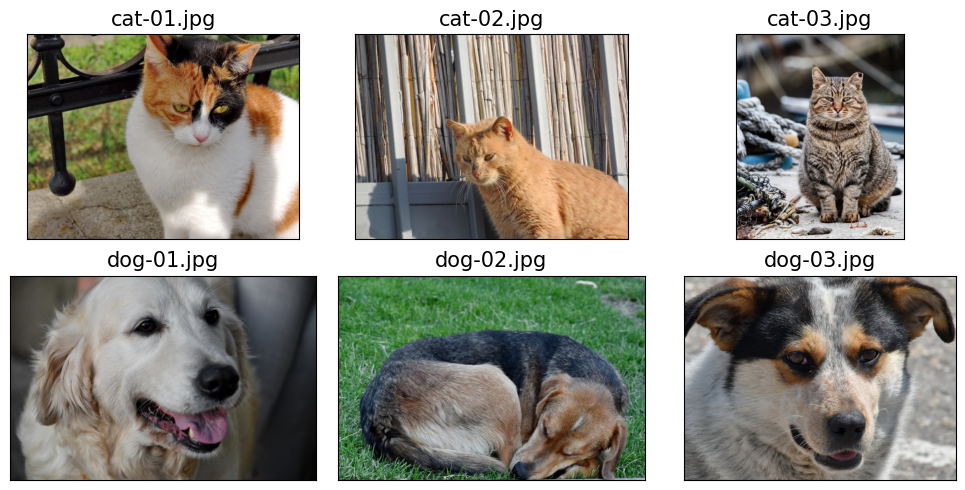

In [128]:
# Отобразим эти примеры
fig = plt.figure(figsize=(10, 5))
for i, file in enumerate(file_list):
    img = Image.open(file)
    print('Размеры изображения: ', np.array(img).shape)
    ax = fig.add_subplot(2, 3, i + 1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(os.path.basename(file), size = 15)
plt.tight_layout()
plt.show()

При работе с файлами изображений легко заметить, что они могут иметь **разные размеры и пропорции**. Например:

* 900×1200 пикселей,
* 800×1200 пикселей,
* 900×742 пикселей.

Такое разнообразие делает данные несогласованными. Поэтому перед использованием в нейросети изображения обычно приводят к **одинаковому размеру**. Это упростит пакетную загрузку и обучение.

Кроме того, в данном наборе данные **не имеют отдельного файла с метками**. В качестве меток используются **имена файлов**:

* изображения собак получают метку `1`,
* изображения кошек — метку `0`.

In [129]:
# Создание меток классов
labels = [1 if 'dog' in os.path.basename(file) else 0 
          for file in file_list]
print(labels)

[0, 0, 0, 1, 1, 1]


In [130]:
# Применим операции по декодированию необработанных содержимых 
# и изменим размер до желаемого, а также преобразуем
# загруженные пикселы в тензоры

img_height, img_width = 80, 120
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_height, img_width))])

Таким образом, мы можем напрямую сопоставить данные (сами изображения) и целевые значения (классы), извлекая их из структуры имён файлов.

In [131]:
# Создание совместного набора данных
class ImageDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(self.file_list[index])
        if self.transform is not None:
            img = self.transform(img)
        label = self.labels[index]
        return img, label

    def __len__(self):
        return len(self.labels)

In [132]:
# Инициализация нашего класса и перебор объединений
image_dataset = ImageDataset(file_list, labels, transform)
for file, label in image_dataset:
    print(file, label)

tensor([[[0.6971, 0.7036, 0.6510,  ..., 0.2820, 0.2383, 0.4570],
         [0.7068, 0.7228, 0.7004,  ..., 0.0946, 0.0899, 0.1645],
         [0.7367, 0.7228, 0.6127,  ..., 0.1531, 0.1851, 0.2183],
         ...,
         [0.5537, 0.5033, 0.4816,  ..., 0.9656, 0.9823, 0.9797],
         [0.5314, 0.5222, 0.4909,  ..., 0.9583, 0.9727, 0.9733],
         [0.4955, 0.5055, 0.4976,  ..., 0.9466, 0.9592, 0.9688]],

        [[0.6420, 0.6501, 0.5974,  ..., 0.2773, 0.2266, 0.4576],
         [0.6672, 0.6843, 0.6541,  ..., 0.0903, 0.0827, 0.1524],
         [0.7031, 0.6796, 0.5444,  ..., 0.1424, 0.1717, 0.2015],
         ...,
         [0.5064, 0.4522, 0.4162,  ..., 0.9260, 0.9465, 0.9447],
         [0.4815, 0.4723, 0.4350,  ..., 0.9218, 0.9407, 0.9438],
         [0.4451, 0.4577, 0.4481,  ..., 0.9112, 0.9286, 0.9414]],

        [[0.5702, 0.5756, 0.5180,  ..., 0.2863, 0.2093, 0.3561],
         [0.5854, 0.6046, 0.5663,  ..., 0.0987, 0.0831, 0.1517],
         [0.6303, 0.5921, 0.4394,  ..., 0.1457, 0.1750, 0.

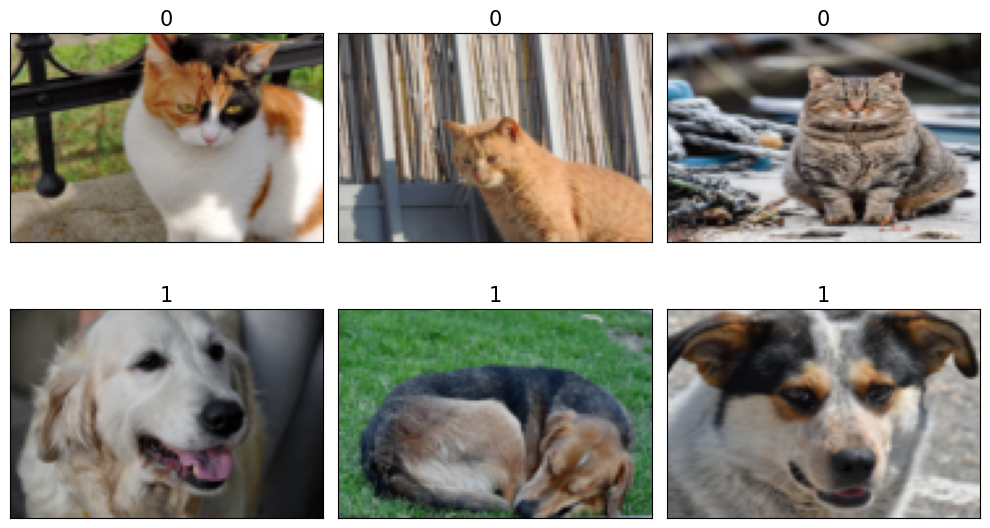

In [133]:
# Отобразим преобразованные изображения
fig = plt.figure(figsize=(10, 6))
for i, example in enumerate(image_dataset):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(np.clip(example[0].numpy().transpose((1, 2, 0)), 0, 1))
    ax.set_title(f'{example[1]}', size = 15)
plt.tight_layout()
plt.show()

---

## Получение доступных наборов данных из `torchvision.datasets`

Модуль **`torchvision.datasets`** предоставляет коллекцию популярных открытых наборов данных изображений для обучения и тестирования моделей глубокого обучения. Аналогично, для текстовых задач можно использовать библиотеку **`torchtext.datasets`**.

Особенности `torchvision.datasets`:

* Наборы данных хорошо структурированы и снабжены описаниями: указаны типы признаков и меток, их размерности и источник.
* Все они являются подклассами `torch.utils.data.Dataset`, что позволяет напрямую применять к ним стандартные инструменты PyTorch (`DataLoader`, трансформации и т. д.).

Таким образом, можно легко подключить готовый датасет и сразу использовать его в учебных проектах.

#### Пример: CelebA

Рассмотрим загрузку набора данных **CelebA** (`torchvision.datasets.CelebA`):

* содержит три подмножества: `'train'`, `'valid'`, `'test'` (задаются параметром `split`);
* изображения открываются в формате `PIL.Image`;
* можно применять пользовательские преобразования через `torchvision.transforms` (например, `ToTensor`, `Resize`);
* доступны разные цели (`target_type`):

  * `'attributes'` — 40 бинарных признаков лица (например, очки, улыбка, цвет волос),
  * `'identity'` — уникальный идентификатор человека,
  * `'landmarks'` — координаты ключевых точек лица (глаза, нос, рот).

Для обучения с учителем можно преобразовать данные в кортеж `(features_tensor, label)`, например, используя 31-й атрибут `'Smiling'` как метку.

#### Пример: MNIST

В качестве второго примера рассмотрим набор **MNIST** (`torchvision.datasets.MNIST`):

* содержит два раздела: `'train'` и `'test'`; необходимо выбрать нужное подмножество;
* изображения сохраняются в формате `PIL.Image` и могут быть преобразованы с помощью `torchvision.transforms` (например, `ToTensor`, `Resize`);
* включает **10 классов изображений** — цифры от 0 до 9.

---

In [134]:
# Вызовем класс со знаменитостями, загрузим и сохраним 
celeba_dataset = torchvision.datasets.CelebA(
    root="Data/celeba",
    split="train",
    target_type="attr",
    download=False
)


In [135]:
# Проверяем относится ли набор данных к классу Dataset
assert isinstance(celeba_dataset, torch.utils.data.Dataset)

In [136]:
# Проверка как выглядят примеры данных
example = next(iter(celeba_dataset))
print(example)

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=178x218 at 0x734937EBA480>, tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1]))


В **CelebA** каждый элемент набора данных представлен как кортеж `(PIL.Image, attributes)`:
* `PIL.Image` — само изображение,
* `attributes` — вектор из 40 бинарных признаков лица.

Чтобы использовать данные для обучения с учителем, нужно преобразовать элемент в формат `(features_tensor, label)`:
* `features_tensor` — тензор изображения после преобразований (`ToTensor()`, `Resize()` и т.д.),
* `label` — целевая метка.

В качестве примера можно взять **атрибут `'Smiling'`** (улыбающиеся), который является **31-м элементом в векторе `attributes`**. Таким образом, для каждого изображения мы получаем пару `(тензор изображения, метка улыбки)`, пригодную для обучения нейросети.

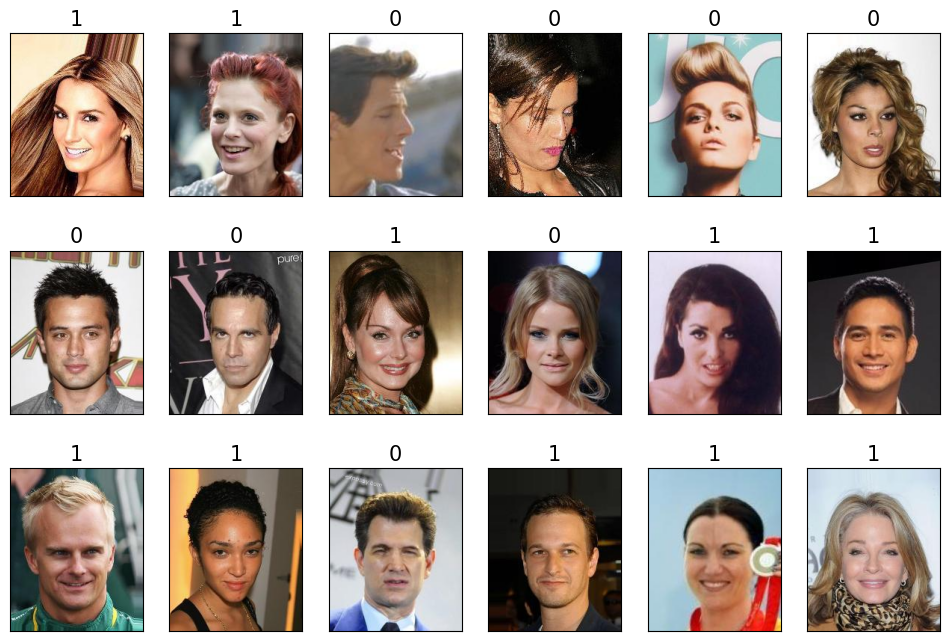

In [137]:
# Визуализируем 18 примеров меток 'Smiling'
fig = plt.figure(figsize=(12, 8))
for i, (image, attributes) in islice(enumerate(celeba_dataset), 18):
    ax = fig.add_subplot(3, 6, i + 1)
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(image)
    ax.set_title(f'{attributes[31]}', size = 15)
plt.show()

In [138]:
# Загрузим и сохраним данные MNIST раздела train
image_path = 'Data/mnist'
mnist_dataset = torchvision.datasets.MNIST(image_path, 'train', download=False)

In [139]:
# Проверяем относится ли набор данных к классу Dataset
assert isinstance(mnist_dataset, torch.utils.data.Dataset)

In [140]:
# Проверка как выглядят примеры данных
example = next(iter(mnist_dataset))
print(example)

(<PIL.Image.Image image mode=L size=28x28 at 0x734937EB80E0>, 5)


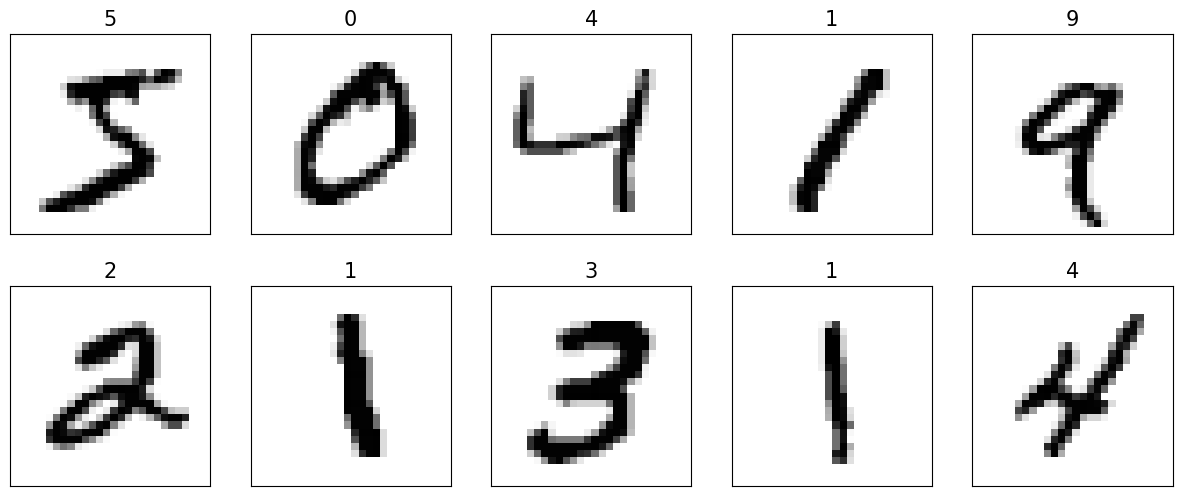

In [141]:
# Преобразуем элементы в кортежи и отобразим 10 примеров
fig = plt.figure(figsize=(15, 6))
for i, (image, label) in islice(enumerate(mnist_dataset), 10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(image, cmap='gray_r')
    ax.set_title(f'{label}', size=15)
plt.show()

<div align="center">

## Построение нейросетевой модели в PyTorch
    
</div>

---

Модуль **`torch.nn`** упрощает создание и обучение нейронных сетей: он позволяет быстро строить как простые прототипы, так и сложные модели. Основой является класс **`nn.Module`**, через который можно гибко определять архитектуру сети и метод прямого распространения. Вместо того чтобы каждый раз вручную писать функцию потерь и обновление градиентов, разработчик может использовать готовые решения из **`torch.nn`** (функции потерь) и **`torch.optim`** (алгоритмы оптимизации). В сочетании с конвейерами данных (`Dataset`, `DataLoader`) это делает процесс обучения простым и удобным. Обученные модели можно сохранять и загружать для повторного использования.

---

## Построение многослойного персептрона для классификации цветков в наборе данных Iris

Применим предопределенные слои для решения задачи классификации уветков ириса (выбор класса между 3 видами) и построим двухслойный персептрон

In [142]:
# Получим данные Iris
iris = load_iris()
X = iris['data']
y = iris['target']

# 100 примеров (2/3) для обучения и 50 (1/3) для теста
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 1./3, random_state = 1)


# Теперь проведем стандартизацию признаков (центрирование по среднему и делением
# на стандартное отклонение) и создадим для train объект Dataset и DataLoader
X_train_norm = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train)
train_ds = TensorDataset(X_train_norm, y_train)
torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle = True)

---

В PyTorch создание моделей обычно начинается с класса **`nn.Module`**, который позволяет объединять слои в нейронную сеть. Для этой задачи мы будем использовать слой **`nn.Linear`** — полносвязный (или плотный) слой, который вычисляет выражение

$$
f(w * x + b)
$$

где (x) — входной тензор, (W) — матрица весов, (b) — вектор смещений, а (f) — функция активации.

Каждый слой принимает выход предыдущего слоя, поэтому его размерность должна быть строго определена. В нашем примере архитектура состоит из двух скрытых слоёв:

* первый принимает **4 признака** на входе и отображает их в **16 нейронов**,
* второй обрабатывает эти 16 значений и выдаёт результат в виде **3 выходных нейронов** — по числу классов.

---

In [143]:
# Определим модель с 2 скрытыми слоями
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        return x

In [144]:
# Инициализируем модель
input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3
model = Model(input_size, hidden_size, output_size)


Здесь мы использовали **сигмоидную функцию** активации для первого слоя и активацию
**softmax** для последнего (выходного) слоя. Активация softmax в последнем слое служит для многоклассовой классификации, поскольку в этой задаче мы имеем три метки класса (именно поэтому у нас три нейрона в выходном слое).
Далее, для нашей задачи мы выбираем функцию потерь на основе **перекрестной энтропии** и оптимизатор `Adam`(надежный метод оптимизации на основе градиента).

In [145]:
# Функция потерь и оптимизатор для нашей модели
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [146]:
# Обучим модель с кол-вом эпох=100
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim = 1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

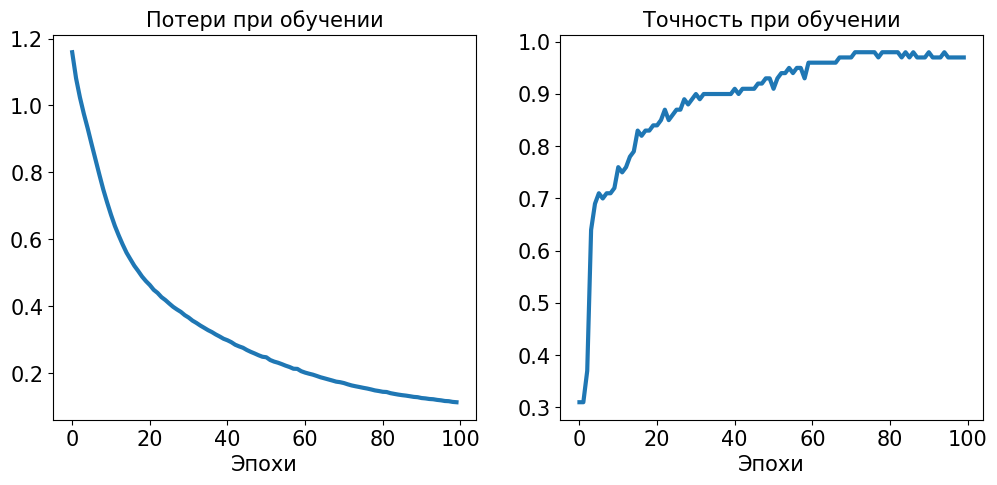

In [147]:
# Визуализируем потери и точность при обучении
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Потери при обучении', size = 15)
ax.set_xlabel('Эпохи', size = 15)
ax.tick_params(axis='both', which = 'major', labelsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Точность при обучении', size = 15)
ax.set_xlabel('Эпохи', size = 15)
ax.tick_params(axis='both', which = 'major', labelsize=15)
plt.show()

In [148]:
# Оценка обученной моделе на тесте 
X_test_norm = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test)
pred_test = model(X_test_norm)
correct = (torch.argmax(pred_test, dim = 1) == y_test).float()
accuracy = correct.mean()
print(f'Точность на тестовых данных: {accuracy:.4f}')

Точность на тестовых данных: 0.9800


---
## Сохранение и повторная загрузка обученной модели

После обучения модель можно сохранить для последующего использования. Обычно её сохраняют в файл с расширением **`.pt`** или **`.pth`**, где хранятся как архитектура, так и обученные параметры. Такая модель при загрузке полностью восстанавливается и сразу готова к применению — можно сразу выполнить оценку на тестовых данных и получить те же результаты, что и до сохранения.

Иногда требуется сохранить только параметры (веса) модели без её архитектуры. В этом случае сохраняется так называемый *словарь состояний*. Для его применения нужно заново создать архитектуру модели вручную, а затем загрузить в неё сохранённые параметры.

Таким образом, в PyTorch поддерживаются оба подхода: сохранение полной модели (архитектура + веса) или только параметров, что удобно для разных сценариев разработки и развертывания.

---

In [156]:
# Сохранение модели (архитектура + веса)
path = 'Model_save/iris_classifier.pt'
torch.save(model, path)

In [157]:
# Загрузка модели обратно
model_new = torch.load(path, weights_only=False)

In [159]:
# Проверка архитектуры модели
model_new.eval()

Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

In [160]:
# Оценим загруженную модель на тесте, чтобы убедиться,
# что результаты такие же, как и раньше
pred_test = model_new(X_test_norm)
correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
print(f'Точность на тестовых данных: {accuracy:.2f}')

Точность на тестовых данных: 0.98


In [161]:
# Сохранение только обученных параметров
path = 'Model_save/iris_classifier_state.pt'
torch.save(model.state_dict(), path)

In [162]:
# Чтобы загрузить сохраненные параметры, нужно построить модель
# как делали раньше и только потом загрузить параметры из файла
# в модель

# Для начала создаем архитектуру такую же как и при обучении
model_new = Model(input_size, hidden_size, output_size)
model_new.load_state_dict(torch.load(path))

<All keys matched successfully>

<div align="center">

## Выбор функций активации для многослойных нейронных сетей
    
</div>

---

До этого мы рассматривали **сигмоидную (логистическую) функцию активации** только в контексте многослойных персептронов:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$


Технически в нейронных сетях можно применять любую дифференцируемую функцию активации, включая линейные, но использование линейных функций на скрытых и выходных слоях малоэффективно: комбинация линейных функций остаётся линейной, что не позволяет моделировать сложные зависимости.

Сигмоидная функция полезна, так как её выход можно интерпретировать как вероятность срабатывания нейрона, что близко к концепции нейрона в мозгу. Однако она имеет ограничения: для больших отрицательных входов её выход близок к нулю, что замедляет обучение и повышает риск застревания в локальном минимуме.

По этой причине на скрытых слоях чаще используют **гиперболический тангенс (tanh)** или другие нелинейные функции. 

---

## Несколько слов о логистической функции

Логистическая функция — это частный случай **сигмоидной функции**, широко используемой для моделирования вероятности принадлежности примера к положительному классу (класс 1) в задаче **бинарной классификации**.

Для входа (z), вычисленного как линейная комбинация признаков:

$$
z = w_0 x_0 + w_1 x_1 + \dots + w_m x_m = \sum_{i=0}^m w_i x_i
$$

логистическая функция вычисляется по формуле:

$$
\text{logistic}(z) = \frac{1}{1 + e^{-z}}
$$

Здесь ($w_0$) — смещение (bias), соответствующее точке пересечения оси (y), когда ($x_0$ = 1).

Выход функции можно интерпретировать как вероятность принадлежности к положительному классу. Для задач **многоклассовой классификации** простое применение логистической функции к каждому классу не работает, так как сумма значений по классам не равна 1. В таких случаях для предсказания метки класса часто используют правило **максимума**: выбирается класс с наибольшим значением функции активации.

---

## Оценка вероятностей классов в мультиклассовой классификации с помощью функции `softmax`


В многоклассовой классификации мы хотим не только предсказать метку класса, но и оценить **вероятность принадлежности примера к каждому классу**. Для этого используется **функция softmax** — «мягкая» альтернатива функции `argmax`.

Пусть модель нейросети выдает на последнем слое **вектор выходов** : $(z = [z_1, z_2, \dots, z_K])$, где (K) — число классов, а каждый элемент (z_i) — это **логит**, т. е. необработанное значение для (i)-го класса, полученное в результате линейного преобразования на последнем слое.

Функция softmax преобразует эти логиты в **вероятности**, которые удовлетворяют двум условиям:

1. $(0 \le p_i \le 1)$ для каждого класса $(i)$,
2. $(\sum_{i=1}^K p_i = 1)$.

Формула для вероятности принадлежности к $(i)$-му классу:


$$
p_i = \frac{e^{z_i}}{\sum_{j=1}^{M} e^{z_j}}
$$

Разберём её по шагам:

1. **Экспоненциальное взятие логитов**: $(e^{z_i})$ делает все значения положительными и усиливает различия между большими и малыми логитами. Большие логиты становятся ещё более доминирующими, а маленькие — почти исчезают.

2. **Сумма по всем классам**: $(\sum_{j=1}^{K} e^{z_j})$ используется для нормализации. Это обеспечивает, что сумма всех вероятностей равна 1, превращая экспоненты в корректное распределение вероятностей.

3. **Деление логита на нормировочную сумму**: каждое значение $(e^{z_i})$ делится на сумму всех экспонент. В результате получаем **относительную вероятность**, показывающую, насколько логит $(z_i)$ выделяется по сравнению с остальными классами.

Пример на практике:

Если есть три класса с логитами $([1, 2, 0.5])$, вычислим вероятности:

1. Вычисляем экспоненты: $([e^1, e^2, e^{0.5}] \approx [2.718, 7.389, 1.649])$
2. Находим сумму: $(2.718 + 7.389 + 1.649 \approx 11.756)$
3. Получаем вероятности:
   $$
   p_1 \approx 0.231, \quad p_2 \approx 0.629, \quad p_3 \approx 0.140
   $$

Вывод: второй класс имеет наибольшую вероятность (0.629), что соответствует логиту $(z_2 = 2)$.

Таким образом, softmax превращает необработанные выходы нейросети в **интерпретируемые вероятности**, удобные для многоклассовой классификации и расчёта функции потерь, например, кросс-энтропии.

Особенности softmax:

* Сумма вероятностей по всем классам равна 1.
* Метка класса с наибольшей вероятностью совпадает с результатом применения `argmax` к выходам модели.
* Предоставляет интерпретируемый нормализованный вывод, полезный для анализа и обучения моделей.

В PyTorch для вычисления вероятностей классов можно использовать функцию `torch.softmax()`. Она применяется к выходам модели по измерению, соответствующему классам, и возвращает тензор с вероятностями для каждого экземпляра данных.

---

## Расширение выходного спектра с использованием гиперболического тангенса

Гиперболический тангенс (**tanh**) — это ещё одна сигмоидная функция, часто используемая в скрытых слоях нейронных сетей.

Его формула:

$$
\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}} = 2 \cdot \text{logistic}(2z) - 1
$$

Где `logistic` — стандартная сигмоидная функция.

**Ключевые особенности tanh:**

1. **Широкий диапазон выходных значений**: $((-1, 1))$ вместо $((0, 1))$ у стандартной сигмоиды.

   * Это помогает градиентам во время обратного распространения ошибки иметь большую амплитуду и уменьшает проблемы «затухающих градиентов» по сравнению с логистической функцией.

2. **Центрирование выхода вокруг нуля**: положительные и отрицательные значения более естественно отражают отклонения от среднего, что ускоряет обучение и улучшает сходимость.

3. **Нелинейность**: как и любая сигмоидная функция, tanh позволяет скрытым слоям нейросети моделировать сложные, нелинейные зависимости между входными признаками.

**Итог**: tanh чаще используют в скрытых слоях, когда важно расширить диапазон выхода и ускорить обучение по сравнению с обычной сигмоидой.

---

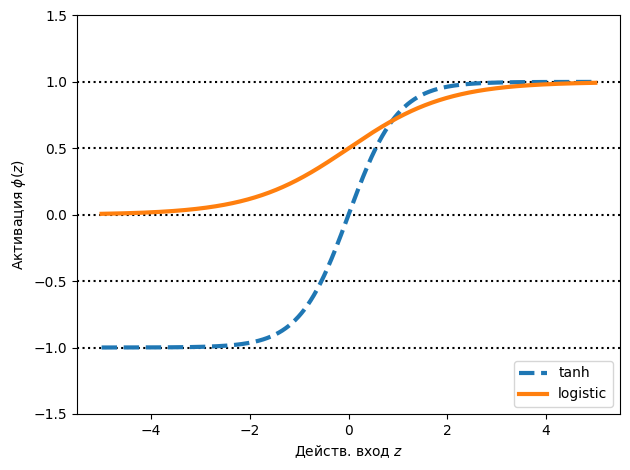

In [165]:
# Наглядное сравнение логистической функции и гиперболического
# тангенса 
def logistic(z):
    return 1 / (1 + np.exp(-z))

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)
    
z = np.arange(-5, 5, 0.005)

log_act = logistic(z)
tanh_act = tanh(z)

plt.ylim([-1.5, 1.5])
plt.xlabel('Действ. вход $z$')
plt.ylabel(r'Активация $\phi(z)$')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')
plt.plot(z, tanh_act,
         linewidth = 3, linestyle = '--',
         label='tanh')
plt.plot(z, log_act,
         linewidth=3,
         label = 'logistic')
plt.legend(loc = 'lower right')
plt.tight_layout()
plt.show()

---

## Спрямленная линейная активация (ReLU)

**ReLU** — одна из самых популярных функций активации в современных глубоких нейронных сетях.

#### Проблема, которую решает ReLU: исчезающий градиент

Сигмоидные функции, такие как **логистическая** и **tanh**, при больших по модулю входных значениях почти перестают изменяться.

* Производная функции становится очень малой.
* Градиенты весов, вычисляемые через эту производную, практически равны нулю.
* Это замедляет обучение и может привести к «залипанию» сети в локальном минимуме.

**Последствия:**

* Градиенты, передаваемые к ранним слоям, постепенно затухают.
* Веса в первых слоях почти не обновляются.
* Сеть обучается медленно или застревает.


#### Определение ReLU

$$
\text{ReLU}(z) = \max(0, z)
$$

**Особенности ReLU:**

1. **Нелинейность** — позволяет нейросети моделировать сложные функции.
2. **Простая производная** — для положительных входов равна 1, что предотвращает затухание градиентов.
3. **Эффективность в глубоких сетях** — ускоряет обучение по сравнению с сигмоидными функциями в скрытых слоях.

**Ограничение:**

* Для отрицательных входов ReLU обнуляет градиент, «выключая» нейрон. Тем не менее, это всё равно лучше, чем полностью затухающие градиенты у сигмоидных функций.


#### Почему ReLU работает лучше

* Градиенты сохраняются в положительной области, что ускоряет обучение.
* Нелинейность ReLU позволяет сети обучать сложные функции, а простота производной уменьшает вычислительные затраты.

**Итог:** ReLU сочетает простоту вычислений с эффективным решением проблемы исчезающих градиентов и является стандартным выбором для скрытых слоев глубоких нейросетей.

---

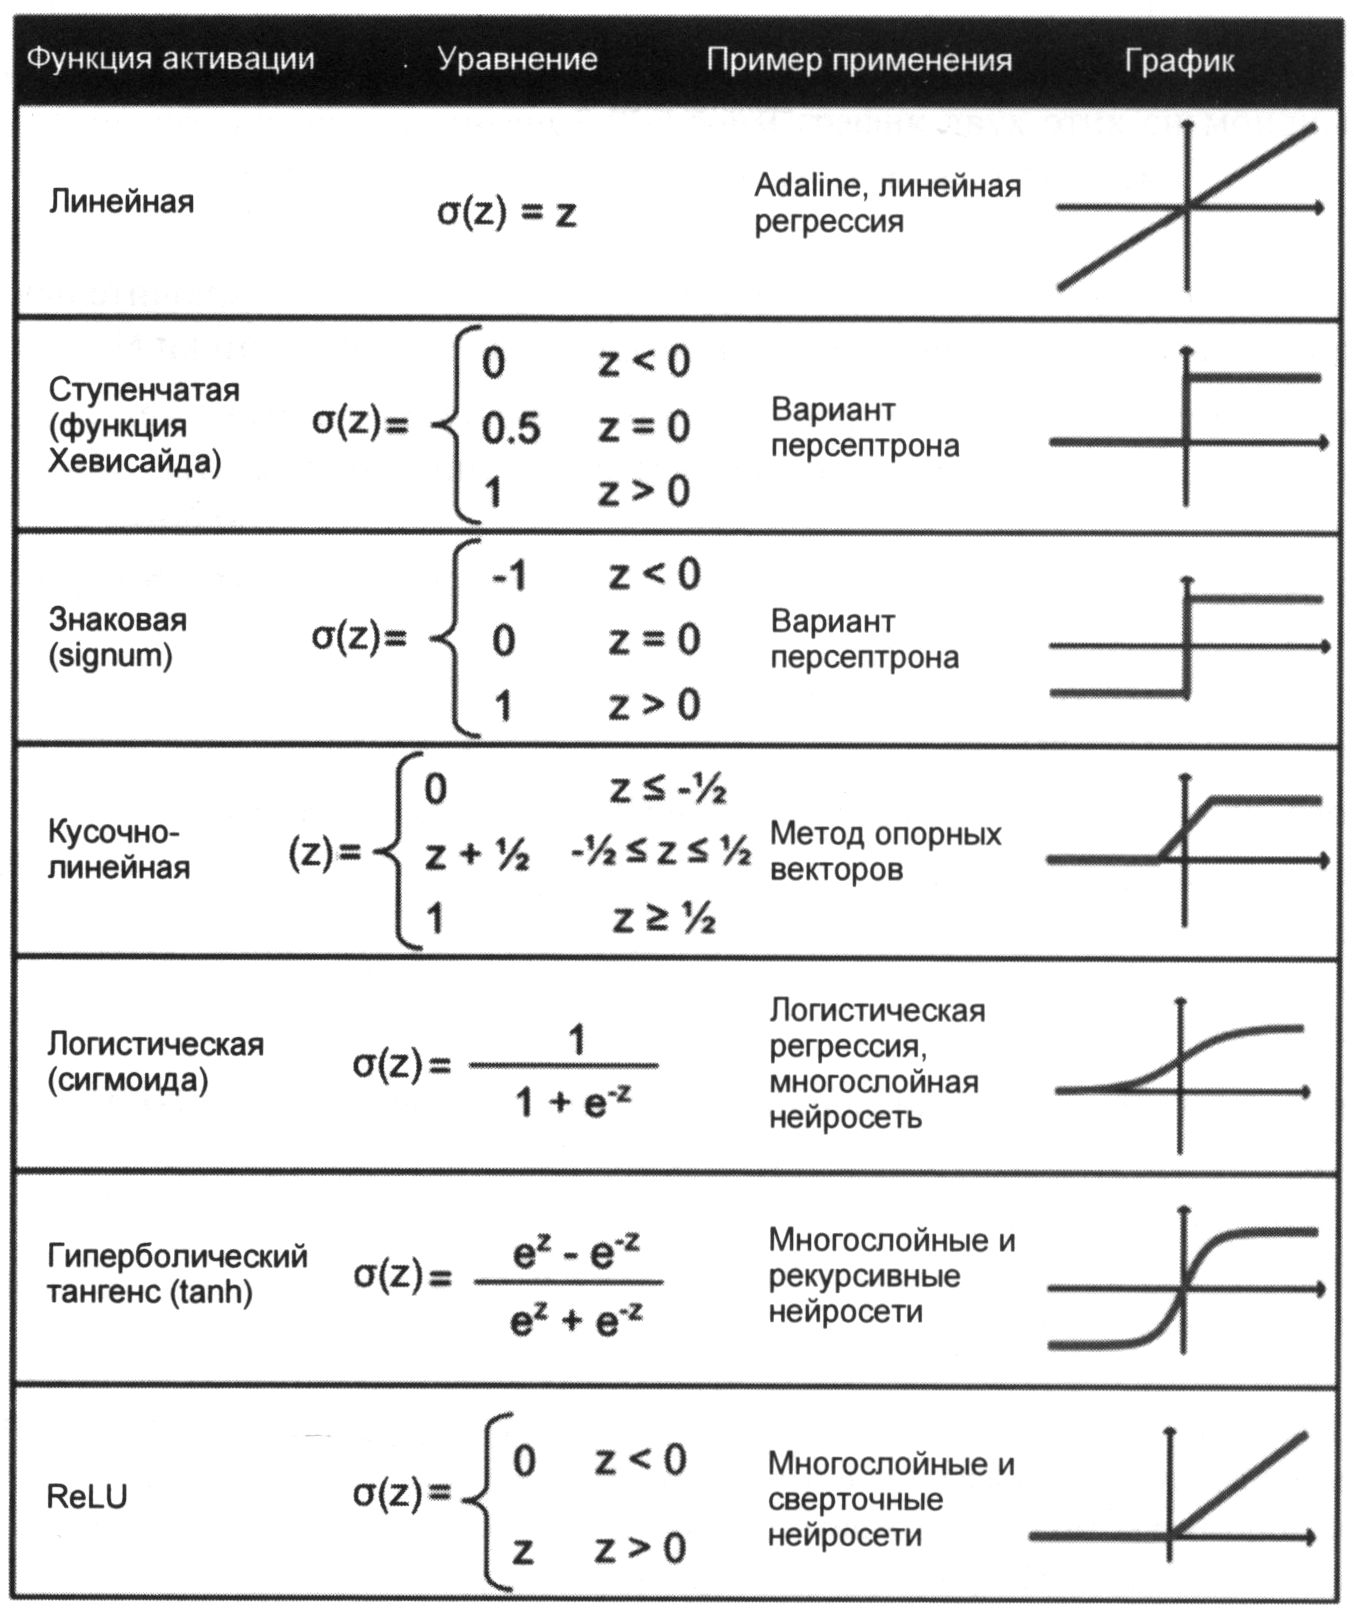

---

<div align="center">

## Заключение
    
</div>

Мы познакомились с **PyTorch** — библиотекой для числовых вычислений и глубокого обучения с открытым исходным кодом.

* Мы рассмотрели создание моделей с нуля, используя базовые операции с **тензорами**, и поняли, что вручную программировать каждую операцию может быть утомительно. PyTorch упрощает эту задачу, позволяя легко строить сложные модели.
* Изучили модуль **`torch.nn`**, который значительно облегчает создание и обучение нейросетевых моделей, а также работу с полносвязными слоями и управлением прямым распространением.
* Ознакомились с различными **функциями активации**, их особенностями и областью применения, включая **tanh**, **softmax** и **ReLU**, а также поняли, как они влияют на обучение сети и решение проблем, таких как исчезающий градиент.

Таким образом, PyTorch предоставляет мощный и гибкий инструментарий для построения, обучения и анализа нейросетевых моделей, сочетая эффективность вычислений с простотой разработки.

---